<a href="https://colab.research.google.com/github/yes-G/FussballPrognose/blob/main/LeaguePrognosis_Public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Poor start! Relegation ahead?

Abysmal performance on the professional playground has different consequences for different people in different sports. One common consequence in football for ardent fans, employees and wannabe punters is the total and utter loss of peace of mind. I too found myself in such a situation with my *favorite club*, and here i describe what i did to reclaim that much treasured peace of mind.

#Disclaimer 
My affiliation with *my favourite* club is a personal matter. The club *analysed* here is a random club lounging in the bottom half of an unrelated(?) league and is NOT *my favourite* club.

In [46]:
import numpy as np
import pandas as pd

import requests
import bs4

import matplotlib.pyplot as plt

In [47]:
#Configuration

#Football league: Spanish 1st division a.k.a. La Liga
League = 'esp-primera-division'

#A proxy for my favourite by abysmally performing team
team = 'Getafe CF'

In [48]:
def split(score):
  """The scores are reported by websites in the following format 7:2 (3:0), 
  where 7:2 is the full time score and (3:0) is the score at half time
  this function returns only the full time score as a string"""
  return score.split('(')[0].strip()

def points(score, invert=False, winPoints=3, drawPoints=1, losePoints=0):
  """How many points did this match give my team? 
  By default, 3 points for a win, 
  1 for a draw, and 0 for a loss
  
  Remember to use invert=True, it is an away game!"""
  x = score.split(':')
  pts = losePoints
  try:
    if invert:
      a = int(x[1])
      b = int(x[0])
    else:
      a = int(x[0])
      b = int(x[1])
    if a > b:
      pts = winPoints
    if a == b: 
      pts = drawPoints
  except:
    pts = None
  return pts 
  print(x)

In [49]:
def ExtractMatchResults(season='2020'):
  s1 = season
  s2 = str(int(season)+1)

  #get the HTML page containing the match results for the season
  r = requests.get(f'https://www.weltfussball.com/alle_spiele/{League}-{s1}-{s2}/')
  html = r.text

  # create a BeautifulSoup object
  bs = bs4.BeautifulSoup(html, "html.parser")

  dfScores = pd.read_html(str(bs.find(class_="standard_tabelle")))[0]
  dfScores.columns = ['Date', 'Time', 'Home', 'Q1', 'Away', 'Score', 'Q2']
  dfScores.Date.fillna(method='ffill', inplace=True)
  dfScores.Home = dfScores.Home.apply(lambda x: None if 'Spieltag' in x else x)
  dfScores.drop(['Q1', 'Q2', 'Time'], axis=1, inplace=True)
  dfScores.dropna(inplace=True)
  dfScores['FT_Score'] = dfScores.Score.apply(split)
  dfScores['FT_Score'] = dfScores['FT_Score'].apply(lambda x: '-:-' if 'verl.' in x else x)
  dfScores.drop(['Score'], axis=1, inplace=True)
  dfScores['Season']=season
  return dfScores
  #dfScores.head(10)

In [50]:
def PrepareFinalPoints(dfMatches):
  year = dfMatches.Season.value_counts().index[0]
  finalTable = pd.DataFrame(data={f'Team-{year}':[], 'Score':[]})
  for name in dfMatches.Home.value_counts().index:
    dfH = dfMatches[(dfMatches.Home == name)].copy()
    #dfH['Home']='H'
    dfH['Points']=dfH.FT_Score.apply(points)

    dfA = dfMatches[(dfMatches.Away == name)].copy()
    #dfA['Home']='A'
    dfA['Points']=dfA.FT_Score.apply(points, invert=True)

    df = pd.concat([dfA, dfH]).sort_index()
    score = df.Points.sum()
    finalTable=finalTable.append({f'Team-{year}':name, 'Score':score}, ignore_index=True)
  finalTable.sort_values(by='Score', ascending=False, inplace=True)
  return finalTable.reset_index(drop=True)

In [51]:
#Extract all the match results for the year 2020-21
results2020 = ExtractMatchResults('2020')

#Extract all the match results for the year 2019-20
results2019 = ExtractMatchResults('2019')

#Extract all the match results for the year 2021-22
results2021 = ExtractMatchResults('2021')

In [52]:
#Prepare the final points table for the season 2020-21
table2020 = PrepareFinalPoints(results2020)

#Prepare the final points table for the season 2020-21
table2019 = PrepareFinalPoints(results2019)

#display(table2020)

#display(table2019)

In [53]:
def ExtractTeamPeformance(team, results):
  df1 = results[(results.Home ==team) | (results.Away == team)].copy().reset_index()
  df1['Opponent'] = df1.apply(lambda x: x['Away'] if x['Home'] == team else x['Home'], axis=1)
  df1['Home'] = df1.apply(lambda x: 'H' if x['Home'] == team else 'A', axis=1)
  df1['Points'] = df1.apply(lambda x: points(x['FT_Score']) if x['Home']=='H' else points(x['FT_Score'], True), axis=1)
  df1.drop(['Away', 'index'], inplace=True, axis=1)
  return df1

In [54]:
try:
  df2019 = ExtractTeamPeformance(team, results2019)
except:
  df2019 = pd.DataFrame()

df2020 = ExtractTeamPeformance(team, results2020)
df2021 = ExtractTeamPeformance(team, results2021)

#Background info. 

*Getafe has lost every single match thusfar,* thereby accumulating a grand total of 0 points from 7 matches, i.e. in 2021-22 the team has displayed a very strong attraction to the very bottom of the abyss.

How did the team perform in the two preceeding seasons?  Or where were we now (after 7 matches) last season and in the one before it?

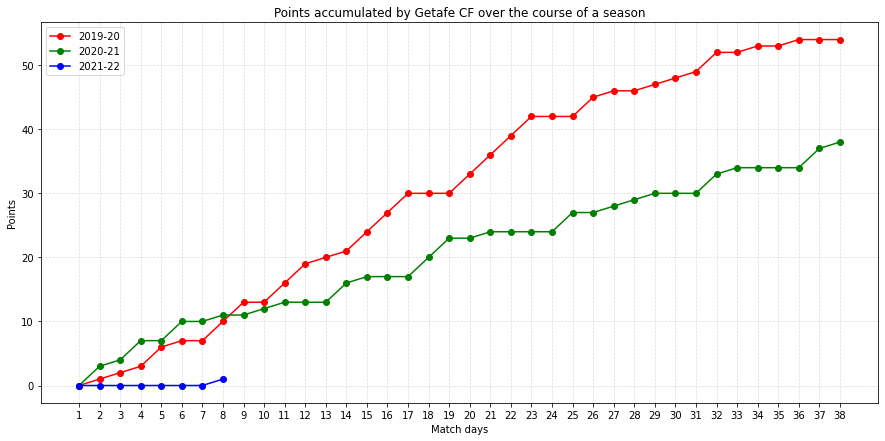

In [55]:
plt.figure(figsize=(15,7));
NumberOfMatches = len(df2021.Opponent.values)
x = np.arange(1, NumberOfMatches+1)
if df2019.empty == False:
  plt.plot(x, df2019.Points.cumsum(), 'r', marker='o', label='2019-20');
plt.plot(x, df2020.Points.cumsum(), 'g', marker='o', label='2020-21');
plt.plot(x, df2021.Points.cumsum(), 'b', marker='o', label='2021-22');
plt.ylabel('Points')
plt.title(f'Points accumulated by {team} over the course of a season')
plt.xlabel('Match days')
plt.grid(color='gainsboro', linestyle='--', linewidth=0.7)
plt.xticks(ticks=x)
plt.legend();

The above the plot answers exactly that question. The match days are on the X-axis and the Y-axis reflects the number of points accumulated until that match day. It is so very clear that on the 7th match the team had boarded the points train and bid its final good bye to the start line fading away in the horizon. In both the past seasons. In this season, it seems to be unclear if the train is scheduled to depart or has terminated at the start line. This chart is the root cause of that aforementioned loss of *peace of ze mind*. 

#What does statistics say? - The independent 2-sample t-test to the rescue

The independent 2-sample t-test can be applied on the points scored in the current current season and the points scored in the "baseline" season. The null hypothesis of the test is that *the means of the two independent populations are equal*. i.e. the performance of the team in the two seasons is "similar". 

If the p-value of the test is greater than the threshold (an arbitraty 5%) then the null hypothesis is not rejected. Food for thought - one can't simply replace *not rejected* with *accepted**. 

In [56]:
from scipy.stats import ttest_ind
a = df2021.Points.copy()
b = df2020.Points.copy()
n = len(a.dropna())
t, p = ttest_ind(a[:n], b[:n])

print(f"p-value is {p*100:.2}%")

p-value is 2.9%


Since, the p-value is less than 5%, the alternative hypothesis (the population means are not equal) may not be rejected.

In english - there is a difference in the perfomance of the team between the two seasons!

The more i mulled and ruminated about it, the more i asked myself - *Are we where we are now, because we are facing the big **powerful teams back-to-back**? Is the result no more than an illusion?*

#The Schedule factor

To qualify the statement, i.e. we performing badly this season, because we are facing the challenging teams first, i tried to answer the question - **if the results are independent of the order of matches, then how would the points graph look like if last season's schedule were like this season's schedule?**

That Q doesn't have a straight forward answer because, 3 new contenders make an appearance in this season's schedule compared to last season. So, a little assumptions was made leading to two different results - and the reality would've been somewhere in between the two results. 

The assumption -
1. the team loses all the matches played against all the new contenders; or
2. the team wins every single match against the new teams. 

In [57]:
def CompareWith(row, withDF, ignore=False):
  ret = row['Points']
  if (row['FT_Score']=='-:-') | (ignore == True):
    data = withDF[(withDF.Home==row['Home']) & (withDF.Opponent == row['Opponent'])]['Points']
    if len(data)>0:
      ret = data.values[0]
    else:
      ret = None
  return ret

In [58]:
if df2019.empty == False:
  df2021_19 = df2021.copy()
  df2021_19['Projection'] = df2021_19.apply(CompareWith, withDF=df2019, axis=1)
  df2021_19['ProjectionFull'] = df2021_19.apply(CompareWith, withDF=df2019, axis=1, ignore=True)

df2021_20 = df2021.copy()
df2021_20['Projection'] = df2021_20.apply(CompareWith, withDF=df2020, axis=1)
df2021_20['ProjectionFull'] = df2021_20.apply(CompareWith, withDF=df2020, axis=1, ignore=True)

In [59]:
def PlotProjection(dfSeasonA, yearA, dfSeasonB, yearB, relegationScoreSeasonB=0):
  """Plot the points projections for the schedule of yearA based on the scores for the sames matches from yearB"""

  NumberOfMatches = len(dfSeasonB.Opponent.values)
  x = np.arange(1, NumberOfMatches+1)

  plt.figure(figsize=(15,10));
  
  #plot the relegation line for Season B on the chart
  if relegationScoreSeasonB > 0:
    plt.hlines(relegationScoreSeasonB,0,NumberOfMatches, 
               color='goldenrod', linestyle='--', 
               label=f'{yearB} relegation level' )

  #plot the cumulative points for season B.
  plt.plot(x, dfSeasonB.Points.cumsum(), 
           color='black', linewidth=3,
           label=f'{yearB} schedule and scores');

  #Plot the projetion since the begining of the season
  ProjFullX1 = dfSeasonA.ProjectionFull.fillna(0).cumsum()
  ProjFullX2 = dfSeasonA.ProjectionFull.fillna(3).cumsum()
  plt.plot(x, ProjFullX1.values, 
           'salmon', linestyle='--', linewidth=2, 
           label=f'{yearA} schedule, {yearB} scores since start of season');
  plt.plot(x, ProjFullX2.values, 'salmon', linestyle=':', linewidth=2);
  plt.fill_between(x, ProjFullX1.values, ProjFullX2.values, alpha=0.1, color='salmon')

  #Plot the projetion since the next match of the season
  ProjX1 = dfSeasonA.Projection.fillna(0).cumsum()
  ProjX2 = dfSeasonA.Projection.fillna(3).cumsum()
  plt.plot(x, ProjX1.values, 'b', linestyle='--', linewidth=2, 
           label=f'{yearA} schedule, {yearB} scores from next match');
  plt.plot(x, ProjX2.values, 'b', linestyle=':', linewidth=2);
  plt.fill_between(x, ProjX1.values, ProjX2.values, alpha=0.1, color='blue')

  plt.plot(x, dfSeasonA.Points.cumsum(), 'green', label=f'{yearA} scores', marker='^', linewidth=3);
  plt.xlabel('Match day (Team played against)')
  plt.xticks(ticks=x, labels=dfSeasonA.Opponent.values, rotation=90)
  plt.ylabel('Cumulative points')
  #plt.vlines(len(dfSeasonA.Points.values) - dfSeasonA.Points.isna().sum() - 1 , 0, max(dfSeasonB.Points.cumsum()),color='green', linewidth=3)
  plt.legend();
  plt.title(f'{team}\'s {yearB} Performance in {yearA}\'s schedule ');
  plt.tight_layout()
  plt.grid(color='gainsboro', linestyle='--', linewidth=0.7)

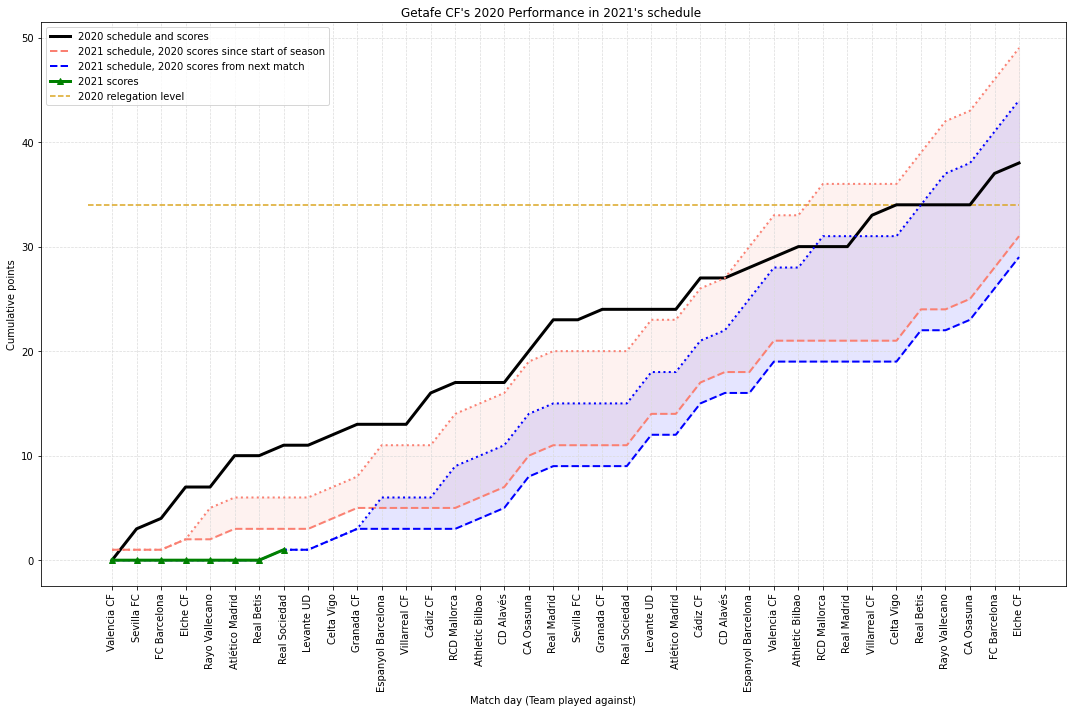

In [60]:
PlotProjection(df2021_20,'2021',df2020,'2020',34)

The answer to that question is found in the above chart. The dashed orange line would've been the worst case performance of the team in the last season if last season's schedule were like this season. And the dotted orange line in the best case perfomance. The orange area between them would've been the area of truth.

The actual points progression of the team in last year's season is the solid black line, and reminds us that not all promising starts are sustained through to the end. The key-take away for me is - last season's start would've been **dismal but not abysmal**, if the schedule were like this season.

#Statistically there is hope!

Applying the same t-test as before to compare the 2021 season and the projection on the scores based on the 2020 season yields the following p-value.

In [61]:
b = df2021_20.ProjectionFull.fillna(3).copy()
a = df2021.Points.copy()
n = len(a.dropna())
t, p = ttest_ind(a[:n], b[:n])

print(f"p-value is {p*100:.3}%")

p-value is 12.8%


Since it is greater than 5%. i.e. The null hypothesis can not be rejected, that the means of the points scored in each match of two seasons are the same. 

If team's psychology is like that of an aspiring Engineer staring down the barrel of a final exam, then the burning question would be - I failed so far, but if i were to be as good as i can be, from **now** - then what? 

*Win all the matches henceforth*? Nah, that is way too optimistic for an engineer. 

*So, last year's performance from now?* Yeah. That sounds more realistic. Improbable, but realistic. 

This performace is the light blue area between the dotted blue line representing the best case wins against the promoted teams the dashed blue line of the worst case against the same teams.

If this season's relegation level is going to be just like last season, then there is a very realistic chance that the team will relegate. Unless...

Unless -
- they pull off wins against every promoted team 
- and win as many games hence forth as they did last season.

In [62]:
#if df2019.empty != True:
#  PlotProjection(df2021_19,'2021',df2019,'2019',36)

In [63]:
finalTable=pd.DataFrame(data={'Team':[], 'Points-Min':[], 'Points-Max':[]})

for team in results2021.Home.value_counts().index:
  try:
    df2020 = ExtractTeamPeformance(team, results2020)
    df2021 = ExtractTeamPeformance(team, results2021)

    df2021_20 = df2021.copy()
    df2021_20['Projection'] = df2021_20.apply(CompareWith, withDF=df2020, axis=1)

    #print(team, df2021_20.Projection.fillna(1).sum())

    finalTable=finalTable.append({
        'Team':team,
        'Points-Min':int(df2021_20.Projection.fillna(0).sum()),
        'Points-Max':int(df2021_20.Projection.fillna(3).sum())
    }, ignore_index=True)
  except:
        finalTable=finalTable.append({
        'Team':team,
        'Points-Min':int(0),
        'Points-Max':int(0)
    }, ignore_index=True)
        
finalTable=finalTable.sort_values(by='Points-Min', ascending=False).reset_index(drop=True)
finalTable.index = np.arange(1, len(finalTable)+1)
finalTable['Points-Max']=finalTable['Points-Max'].astype(int)
finalTable['Points-Min']=finalTable['Points-Min'].astype(int)
display(finalTable.iloc[:-3])

,Team,Points-Min,Points-Max
1,Sevilla FC,71,83
2,Atlético Madrid,70,85
3,Real Madrid,68,80
4,FC Barcelona,63,81
5,Real Sociedad,56,71
6,Villarreal CF,52,64
7,Real Betis,50,62
8,Athletic Bilbao,48,60
9,Celta Vigo,41,59
10,CA Osasuna,39,48


In order to understand where the 2021-22 season's relegation cut off could be, a similar projection was performed for all the other teams in the league. The projected final scores are shown in the above table. The "promoted" teams have been given 0 points, although this is not accurate, because it is not possible to predict where they will land based on last season's performance. The relegation score will lie between 28 and 43 points. And as of now, the team is on track to score between 29 and 44 points, and hence definately **at a slight risk of relegation**, unless they improve **or others perform poorly**.